* In deep learning the encoder-decoder model is a type of neural network that is mainly used for tasks where both the input and output are sequences. This architecture is used when the input and output sequences are not the same length for example translating a sentence from one language to another, summarizing a paragraph, describing an image with a caption or convert speech into text. It works in two stages:

1. Encoder: The encoder takes the input data like a sentence and processes each word one by one then creates a single, fixed-size summary of the entire input called a context vector or latent space.

2. Decoder: The decoder takes the context vector and begins to produce the output one step at a time.

3. For example, in machine translation an encoder-decoder model might take an English sentence as input (like "I am learning AI") and translate it into French ("Je suis en train d'apprendre l'IA").

---

# Encoder-Decoder Model Architecture

In an encoder-decoder model both the encoder and decoder are separate networks each one has its own specific task. These networks can be different types such as Recurrent Neural Networks (RNNs), Long Short-Term Memory networks (LSTMs), Gated Recurrent Units (GRUs), Convolutional Neural Networks (CNNs) or even more advanced models like Transformers.

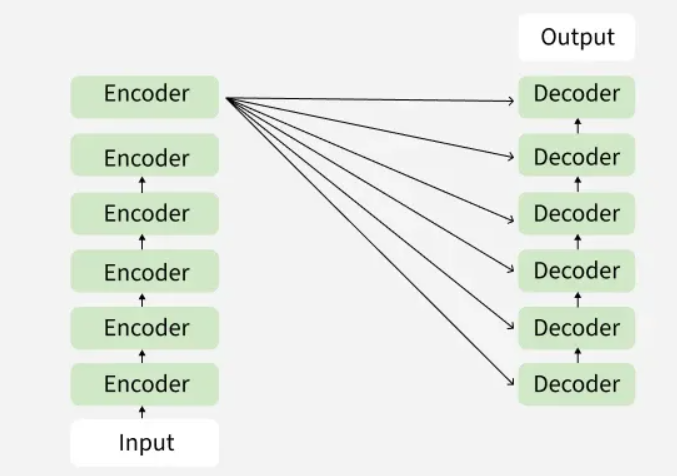

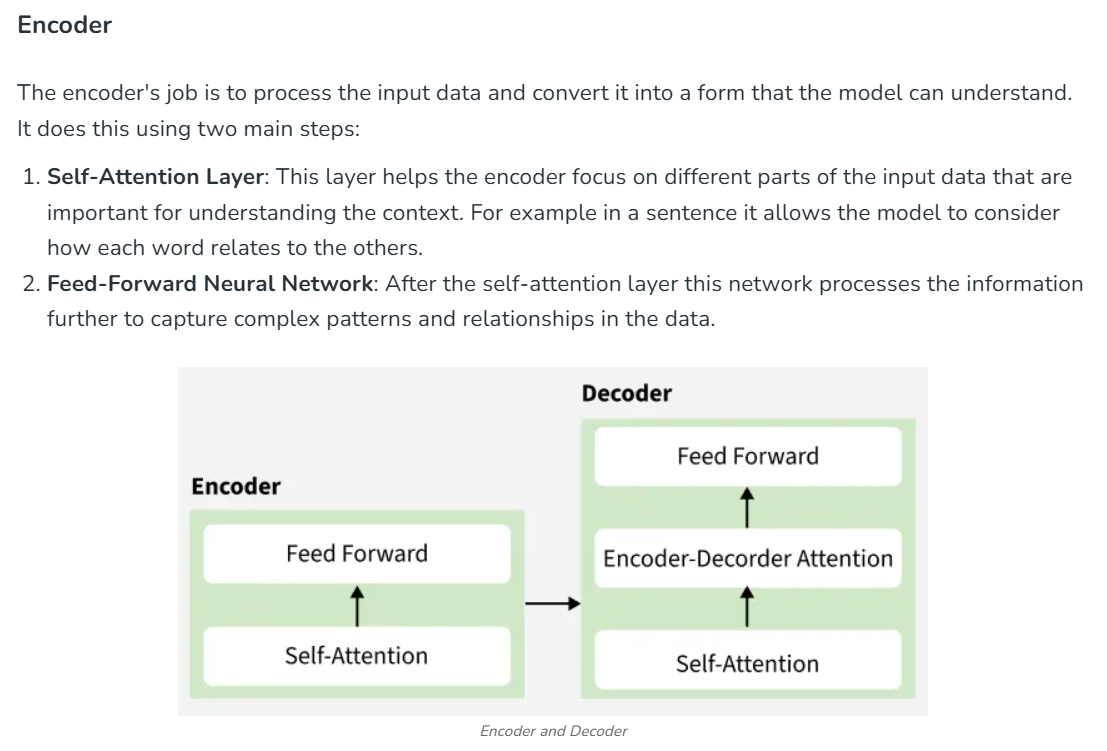
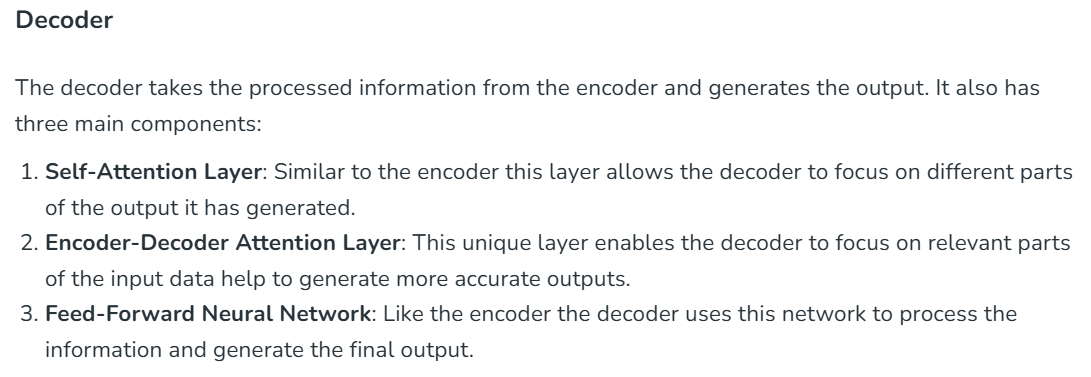

---

# Working of Encoder Decoder Model

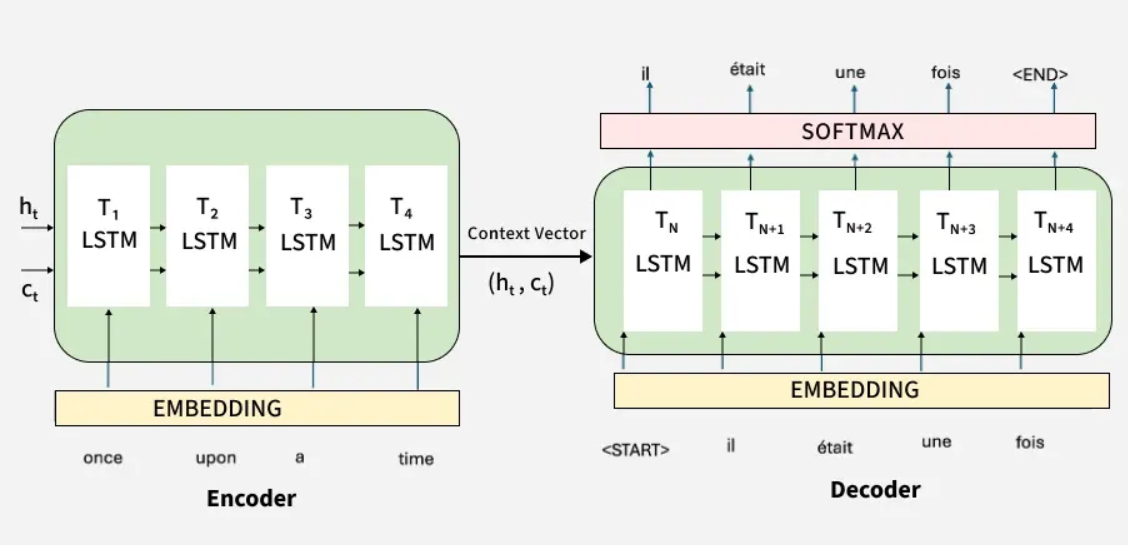

#### Step 1: Tokenizing the Input Sentence

* The sentence "I am learning AI" is first broken into tokens: ["I", "am", "learning", "AI"].
* Each word (token) is converted into a vector that a machine can understand. This process is called embedding.

#### Step 2: Encoding the Input

* The Encoder processes these embeddings using "self-attention".
* Self-attention helps the encoder to focus on important words. For example while encoding "learning", it understands its relation with "I" and "AI."
* After processing the encoder generates a Context Vector which captures the meaning of the entire sentence. For example in the image The arrows show how each word relates to the others during encoding. The final output from the encoder is the context representation 

#### Step 3: Passing the Context to the Decoder

* The Context Vector is passed to the Decoder as shown in image.
* It acts like a summary of the full input sentence.

#### Step 4: Decoder Generates Output Step-by-Step

* The Decoder uses the context and starts creating the output one word at a time.
* First it predicts the first word then uses that to predict the second word and so on

#### Step 5: Decoder Attention

* While generating each word the decoder attends to different parts of the input sentence to make better predictions.
* For example when translating "learning," it might pay more attention to the word "learning" in the input.

#### Step 6: Producing the Final Output

* The decoder continues generating until the full translated sentence is produced.
* Each output token depends on the previous ones and the input context. You finally see the output tokens generated on the right side of the diagram completing the translation.

---

# Implementation of Encoder and Decoder

#### Step 1: Import Libraries and Load dataset

In [ ]:
import numpy as np, pandas as pd, string
from string import digits
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

lines = pd.read_csv("/content/Hindi_English_Truncated_Corpus.csv", encoding='utf-8')
lines = lines[lines['source'] == 'ted'][['english_sentence', 'hindi_sentence']].dropna().drop_duplicates()
lines = lines.sample(n=25000, random_state=42)

#### Step 2: Text Cleaning
Here it remove punctuation and digits and converts text to lowercase and strips whitespace.

def clean_text(text):
    exclude = set(string.punctuation)
    text = ''.join(ch for ch in text if ch not in exclude)
    text = text.translate(str.maketrans('', '', digits))
    return text.strip().lower()

lines['english_sentence'] = lines['english_sentence'].apply(clean_text)
lines['hindi_sentence'] = lines['hindi_sentence'].apply(clean_text)
lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x: 'start_ ' + x + ' _end')

#### Step 3: Tokenization
Converts text to sequences of integers using word indices. Hindi tokenizer keeps_because of special tokens.

In [ ]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(lines['english_sentence'])
eng_seq = eng_tokenizer.texts_to_sequences(lines['english_sentence'])

hin_tokenizer = Tokenizer(filters='')  
hin_tokenizer.fit_on_texts(lines['hindi_sentence'])
hin_seq = hin_tokenizer.texts_to_sequences(lines['hindi_sentence'])

#### Step 4: Padding
Pads sequences to uniform length

In [ ]:
max_eng_len = max(len(seq) for seq in eng_seq)
max_hin_len = max(len(seq) for seq in hin_seq)

encoder_input = pad_sequences(eng_seq, maxlen=max_eng_len, padding='post')
decoder_input = pad_sequences(hin_seq, maxlen=max_hin_len, padding='post')

decoder_target = np.zeros((decoder_input.shape[0], decoder_input.shape[1], 1))
decoder_target[:, 0:-1, 0] = decoder_input[:, 1:]

#### Step 5: Define Model Architecture
Encoder:

It embeds English input and Passes through LSTM. Keeps hidden (state_h) and cell state (state_c) to pass to decoder.

In [ ]:
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(eng_vocab_size, latent_dim)(encoder_inputs)
enc_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(enc_emb)
encoder_states = [state_h, state_c]

Decoder:

It embeds Hindi input. Uses initial states from encoder and Outputs probability distribution over Hindi vocabulary at each time step.

In [ ]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(hin_vocab_size, latent_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(hin_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#### Step 6. Compile and Train
Trains on source (encoder_input) and target (decoder_input) with shifted targets and uses RMSProp optimizer and cross-entropy loss.

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
model.fit([encoder_input, decoder_input], decoder_target, batch_size=64, epochs=20, validation_split=0.2)

#### Step 7: Inference Models
To translate new sentences after training:

Encoder Inference: Returns hidden/cell states given an English sentence.

In [ ]:
encoder_model_inf = Model(encoder_inputs, encoder_states)

Decoder Inference:

In [ ]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
dec_inf_emb = dec_emb_layer(decoder_inputs)
dec_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(dec_inf_emb, initial_state=decoder_states_inputs)
decoder_outputs_inf = decoder_dense(dec_outputs_inf)
decoder_model_inf = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs_inf, state_h_inf, state_c_inf])

#### Step 8: Reverse Lookup
Used to convert indices back to words during decoding.

In [ ]:
reverse_eng = {v: k for k, v in eng_tokenizer.word_index.items()}
reverse_hin = {v: k for k, v in hin_tokenizer.word_index.items()}

#### Step 9: Translate Function
It prepares input sentence. Starts decoding with <start> token and Iteratively predicts next word and feeds it back until <end> is predicted. and the test the model with example

In [ ]:
def translate(sentence):
    sentence = clean_text(sentence)
    seq = eng_tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=max_eng_len, padding='post')
    states = encoder_model_inf.predict(padded)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = hin_tokenizer.word_index['start_']

    decoded = []
    while True:
        output, h, c = decoder_model_inf.predict([target_seq] + states)
        token_index = np.argmax(output[0, -1, :])
        word = reverse_hin.get(token_index, '')

        if word == '_end' or len(decoded) >= max_hin_len:
            break

        decoded.append(word)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = token_index
        states = [h, c]

    return ' '.join(decoded)
    
print("English: And")
print("Hindi:", translate("And"))

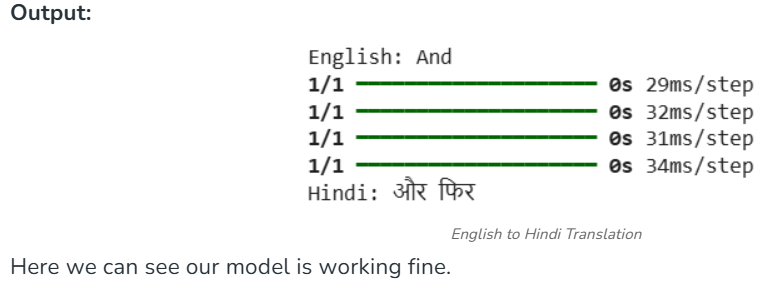